# Analysis of the results

In [1]:
import numpy as np
import os
import csv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from PIL import Image
from utils import *

In [167]:
fname = "../results/queries_class.txt"

queries_class = get_queries(fname)
queries_regressor = get_queries("../results/queries_regressor.txt")

In [170]:
queries_fusion = get_fusion(queries_class, queries_regressor, fusion=lambda x, y: (x + y) / 2)

In [171]:
print(get_weighted_map(queries_fusion))

0.912023561074167


In [56]:
plt.rcParams.update({'font.size': 22})

In [258]:
def plot_queries(words_list, queries, first_bests=3):
    words = len(words_list)
    nquerries = len(list(queries.keys()))
    res = len(list(queries.values())[0])
    
    for i, qr in enumerate(words_list):
        idx, score, pair = queries[qr][0]
        nb_rel = np.sum([elt[2] for elt in queries[qr]])
        plt.subplot(words, first_bests+1, 1 + i*(first_bests+1))
        im = Image.open('../dataset/word-{:06d}.png'.format(int(qr)))
        plt.imshow(im)
        plt.axis('off')
        plt.title('Query word \n(nb occurrences: {})'.format(nb_rel))

        plt.subplot(words, first_bests+1, 2 + i*(first_bests+1))
        im = Image.open('../dataset/word-{:06d}.png'.format(int(idx)))
        plt.imshow(im)
        plt.axis('off')
        plt.title(('True' if int(pair) == 1 else 'False') + '\nScore : {:.3f}'.format(float(score)))
        for j in range(first_bests-1):
            idx, score, pair = queries[qr][j + 1]
            plt.subplot(words, first_bests+1, 3 + j + i*(first_bests+1))
            im = Image.open('../dataset/word-{:06d}.png'.format(int(idx)))
            plt.imshow(im)
            plt.axis('off')
            plt.title(('True' if int(pair) == 1 else 'False') + '\nScore : {:.3f}'.format(float(score)))


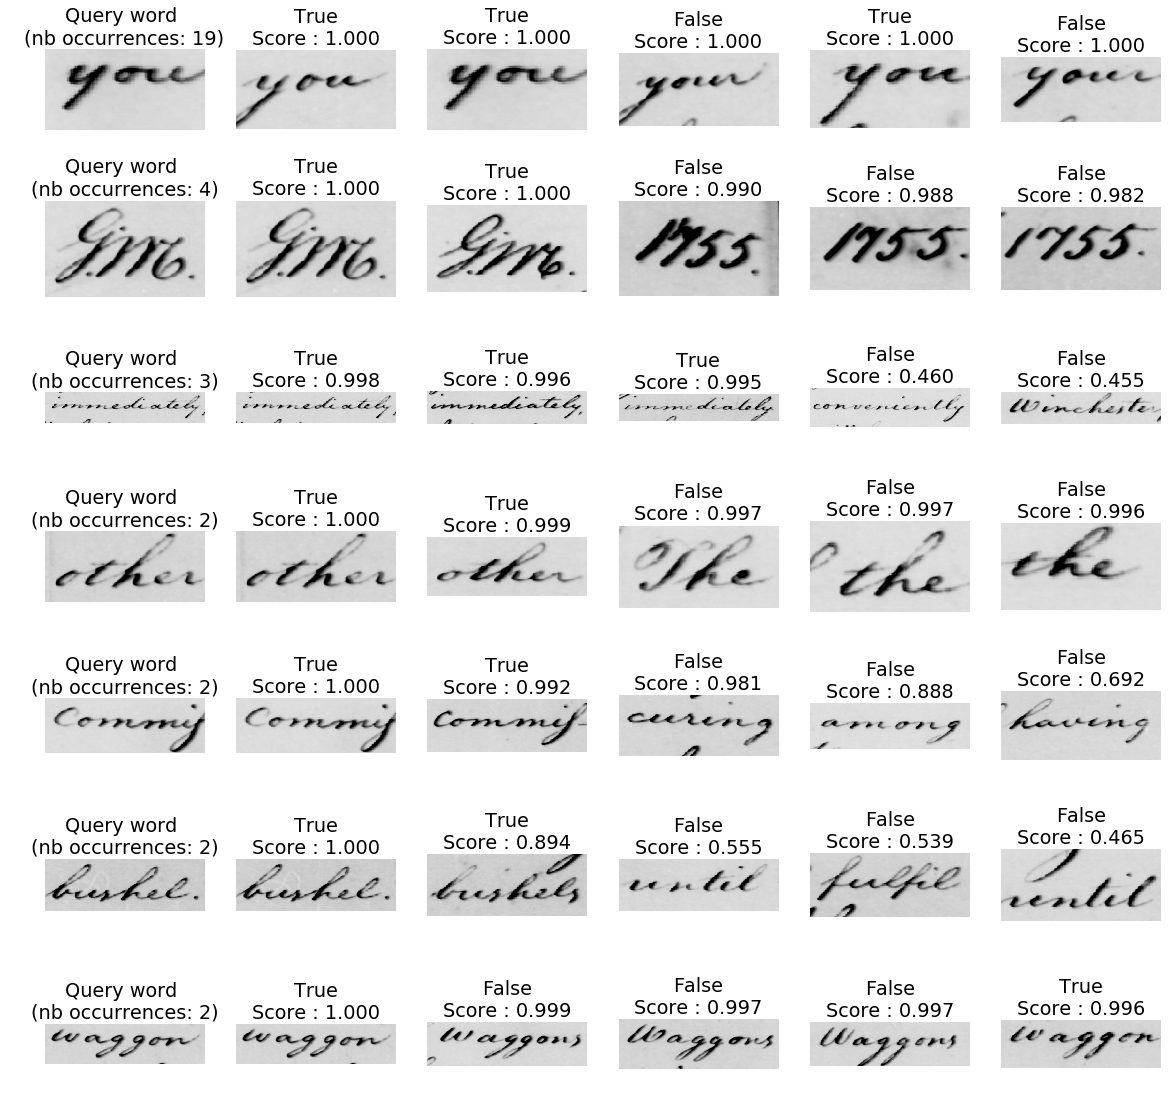

In [259]:
queries = queries_fusion
chosen = [4263, 4288, 4037, 3722, 3809, 3938, 4837]


words = 5
first_bests = 3
nquerries = len(list(queries.keys()))
res = len(list(queries.values())[0])

plt.figure(figsize=(20,20))

keys = list(queries.keys())

np.random.shuffle(keys)
plot_queries(chosen, queries_fusion, first_bests=5)
plt.savefig("queries.png", dpi=300)
plt.show()

In [203]:
curves = np.loadtxt("../results/scores.csv", delimiter=',')
plt.rcParams.update({'font.size': 16})

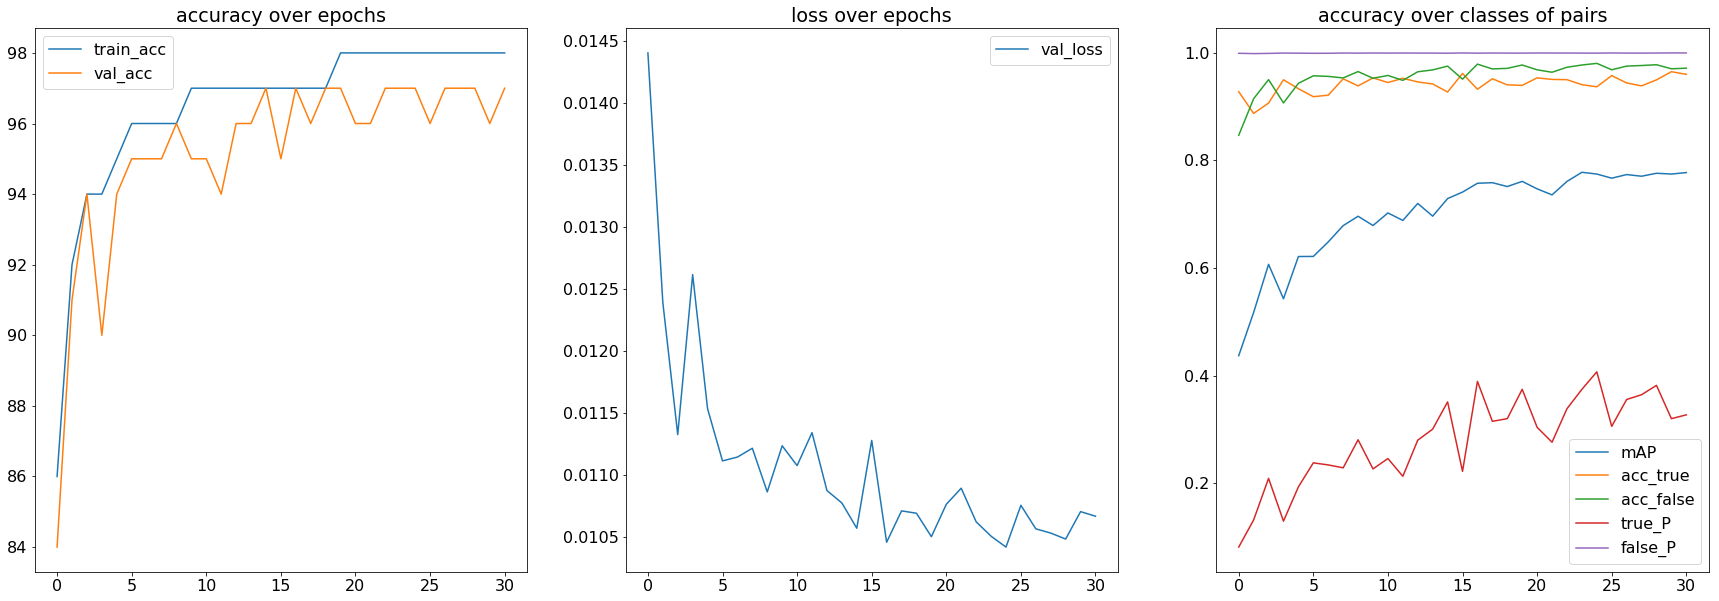

In [202]:
labels = ['train_acc', 'val_acc', 'val_loss', 'time', 'mAP', 'acc_true', 'acc_false', 'true_P', 'false_P']
plt.figure(figsize = (30,10))
plt.subplot(131)
plt.plot(curves[:,0], label = labels[0])
plt.plot(curves[:,1], label = labels[1])
plt.title('accuracy over epochs')
plt.legend()

plt.subplot(132)
plt.plot(curves[:,2], label = labels[2])
plt.title('loss over epochs')
plt.legend()

plt.subplot(133)
for i in range(5):
    plt.plot(curves[:,4+i], label = labels[4+i])
plt.title('accuracy over classes of pairs')
plt.legend()
plt.savefig("curves.png", dpi=300)
plt.show()

# mAP according to word length

In [187]:
words = []

with open("../dataset/words.txt", "r") as f:
    words = [line.strip() for line in f]

In [188]:
def get_length_hist(queries, words):
    max_length = max([len(w) for w in words])

    hist = [0 for i in range(max_length + 1)]
    counters = [0 for i in range(max_length + 1)]

    for key in queries.keys():
        idx = len(words[key])
        score, nb_rel = get_AP(queries[key])
        if nb_rel > 0:
            hist[idx] += score / nb_rel
            counters[idx] += 1
    return [hist[i] / max(1, counters[i]) for i in range(len(hist))], counters

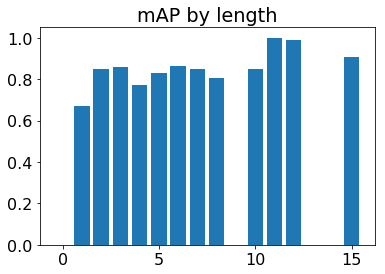

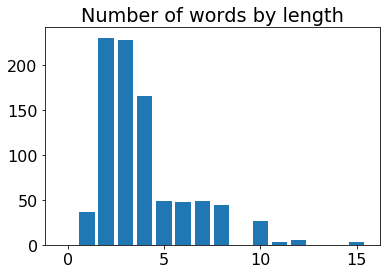

In [346]:
hist_fusion, counters = get_length_hist(queries_fusion, words)

plt.bar([i for i in range(len(hist_fusion))], hist_fusion)
plt.title("mAP by length")
plt.savefig("length.png", dpi=300)
plt.show()
plt.bar([i for i in range(len(hist_fusion))], counters)
plt.title("Number of words by length")

plt.show()

## mAP according to word frequency

In [120]:
def get_freq_hist(queries, words, maxi=75):
    hist = [0 for i in range(maxi)]
    counters = [0 for i in range(maxi)]

    for key in queries.keys():
        score, nb_rel = get_AP(queries[key])
        if nb_rel > 0 and nb_rel < maxi:
            idx = nb_rel
            hist[idx] += score / nb_rel
            counters[idx] += 1
    return [hist[i] / max(1, counters[i]) for i in range(len(hist))], counters

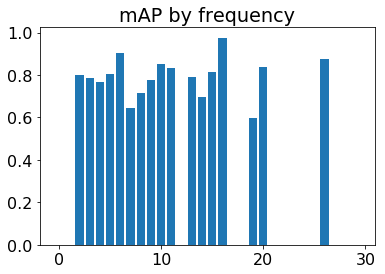

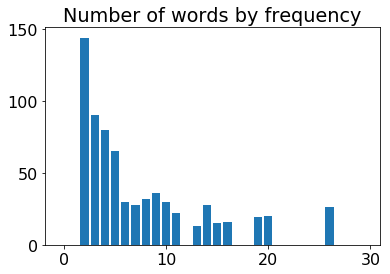

In [347]:
hist_fusion, counters = get_freq_hist(queries_fusion, words, maxi=30)
hist_class, counters = get_freq_hist(queries_class, words, maxi=30)
hist_regressor, counters = get_freq_hist(queries_regressor, words, maxi=30)

plt.bar([i for i in range(len(hist_fusion))], hist_fusion)
plt.title("mAP by frequency")
plt.savefig("frequency.png", dpi=300)
plt.show()
plt.bar([i for i in range(len(hist_fusion))], counters)
plt.title("Number of words by frequency")
plt.show()

## Score evolution for a query

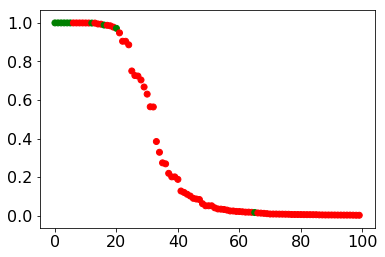

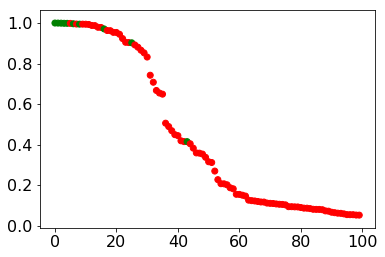

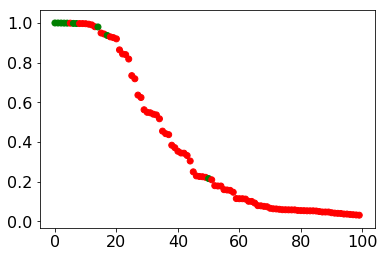

In [254]:
q = 4654# the: 4191 #Alexandria : 4654 # 4047 : W # 3893: Fort
maxi = 100
scores_class = queries_class[q][:maxi]
scores_regressor = queries_regressor[q][:maxi]
scores_fusion = queries_fusion[q][:maxi]

blue = "green"
red = "red"

y_class = [elt[1] for elt in scores_class]
y_regressor = [elt[1] for elt in scores_regressor]
y_fusion = [elt[1] for elt in scores_fusion]
c_class = [blue if elt[2] == 1 else red for elt in scores_class]
c_regressor = [blue if elt[2] == 1 else red for elt in scores_regressor]
c_fusion = [blue if elt[2] == 1 else red for elt in scores_fusion]

plt.scatter(range(len(y_class)), y_class, color=c_class)
plt.show()
plt.scatter(range(len(y_class)), y_regressor, color=c_regressor)
plt.show()
plt.scatter(range(len(y_class)), y_fusion, color=c_fusion)
plt.show()


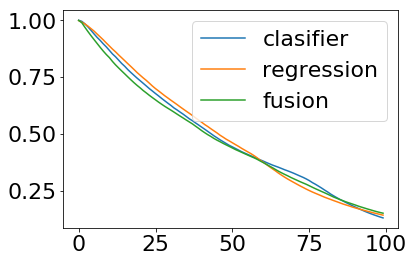

In [184]:
maxi=100
scores_class = np.zeros((maxi,))
scores_regression = np.zeros((maxi,))
scores_fusion = np.zeros((maxi,))

n = 0

for q in queries_class.keys():
    scores_class += np.array([elt[1] for elt in queries_class[q][:maxi]])
    scores_regression += np.array([elt[1] for elt in queries_regressor[q][:maxi]])
    scores_fusion += np.array([elt[1] for elt in queries_fusion[q][:maxi]])
    n += 1
scores_class /= n
scores_regression /= n
scores_fusion /= n

plt.plot(scores_class, label="clasifier")
plt.plot(scores_regression, label="regression")
plt.plot(scores_fusion, label="fusion")
plt.legend()
plt.show()

## mAP for new words

In [260]:
import os, re

string_transform = {
    "strict": lambda w: w,
    "lower": lambda w: w.lower(),
    "ponctuation": lambda w: re.sub("[^\w\s]", "", w),
    "all": lambda w: re.sub("[^\w\s]", "", w).lower()
}

transf = string_transform["ponctuation"]

words = []

with open("../dataset/words.txt", "r") as f:
    words = [transf(line.strip()) for line in f]

new = []
redondant_new = set()

for i, elt in enumerate(words[3697:]):
    idx = i + 3697
    if elt not in words[:3697]:
        if elt in new:
            redondant_new.add(elt)
        new.append(elt)
        
redondant_idx = []
for i, elt in enumerate(words):
    if elt in redondant_new:
        redondant_idx.append(i)

In [261]:
print("number of queries of words that don't appear in training set: {}".format(len(redondant_idx)))

number of queries of words that don't appear in training set: 46


In [266]:
queries_new = {}
queries_new_simple = {}
for key in queries_fusion.keys():
    if key in redondant_idx:
        queries_new[key] = queries_fusion[key]
    if key in redondant_idx_simple:
        queries_new_simple[key] = queries_fusion[key]

In [263]:
redondant_new_simple = redondant_new - set([
    '10th',
    '11th',
    '16th',
    '20th',
    '22d',
    '8th'
])

In [264]:
redondant_idx_simple = []
for i, elt in enumerate(words):
    if elt in redondant_new_simple:
        redondant_idx_simple.append(i)

In [349]:
print("number of queries of words that don't appear in training set and which do not contain numbers: {}".format(len(redondant_idx_simple)))

number of queries of words that don't appear in training set and which do not contain numbers: 29


In [350]:
print("mAP for new words:", get_map(queries_new))

mAP for new words: 0.6856755604145495


In [351]:
print("mAP for new words without numbers: ", get_map(queries_new_simple))

mAP for new words without numbers:  0.8399558391799772


## Study weights

In [352]:
from models import TwoChannelsClassifier, TwoChannelsRegressor
import torch

classifier = TwoChannelsClassifier()
regressor = TwoChannelsRegressor()

classifier.load_state_dict(torch.load("../results/model_class.pth", map_location="cpu"))
regressor.load_state_dict(torch.load("../results/model_regressor.pth", map_location="cpu"))

classifier.eval()
regressor.eval()

TwoChannelsRegressor(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1344, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

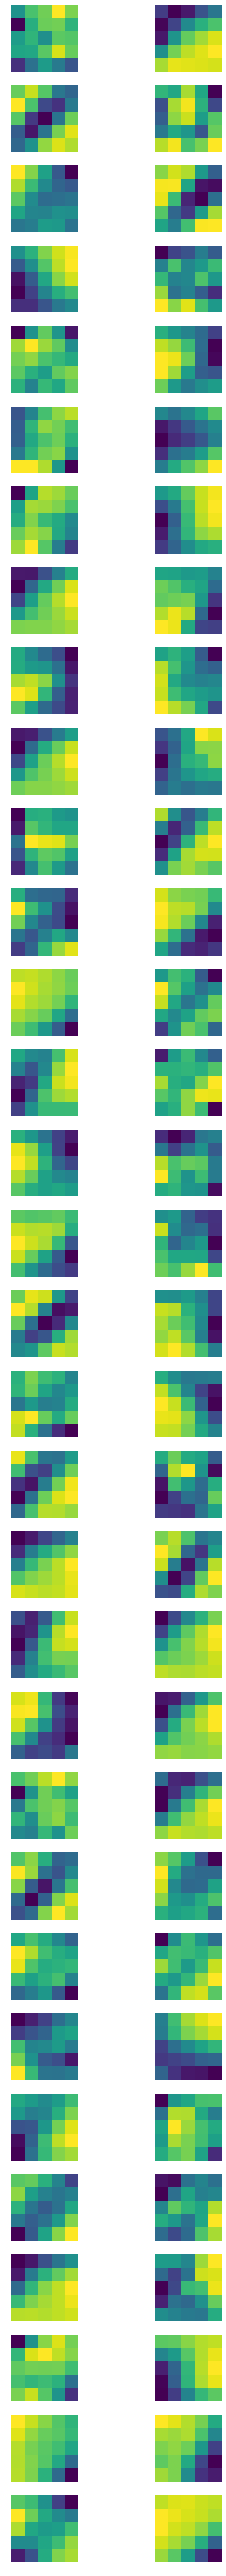

In [342]:
conv1 = regressor.conv1.weight.data.numpy()
def plot_weights(weights):
    w1 = weights[:, 0, :, :]
    w2 = weights[:, 1, :, :]
    for j in range(weights.shape[0]):
        a = w1[j]
        b = w2[j]
        ax1 = plt.subplot(weights.shape[0], 2, 1 + 2 * j)
        ax2 = plt.subplot(weights.shape[0], 2, 1 + 2 * j + 1)
        ax1.imshow(a)
        ax1.axis("off")
        ax2.imshow(b)
        ax2.axis("off")

plt.figure(figsize=(10,100))
plot_weights(conv1)
plt.show()

In [325]:
from data import validation_transform_before, transform_after

In [340]:
from utils import NestedStruct
from PIL import Image
import torchvision.transforms as transforms

args = NestedStruct(model="2channels", binarize=False, normalize=True)

a = validation_transform_before(args)(Image.open("../dataset/word-004696.png"))
b = validation_transform_before(args)(Image.open("../dataset/word-004654.png"))
c = validation_transform_before(args)(Image.open("../dataset/word-004000.png"))
a = transforms.ToTensor()(a)
b = transforms.ToTensor()(b)
c = transforms.ToTensor()(c)
sample_a = torch.cat((a, torch.zeros(a.size())), 0).unsqueeze(0)
sample_b = torch.cat((torch.zeros(b.size()), b), 0).unsqueeze(0)

In [336]:
out_a = classifier.conv1(sample_a).squeeze(0).unsqueeze(1).data.numpy()
out_b = classifier.conv1(sample_b).squeeze(0).unsqueeze(1).data.numpy()
out = np.concatenate((out_a, out_b), 1)

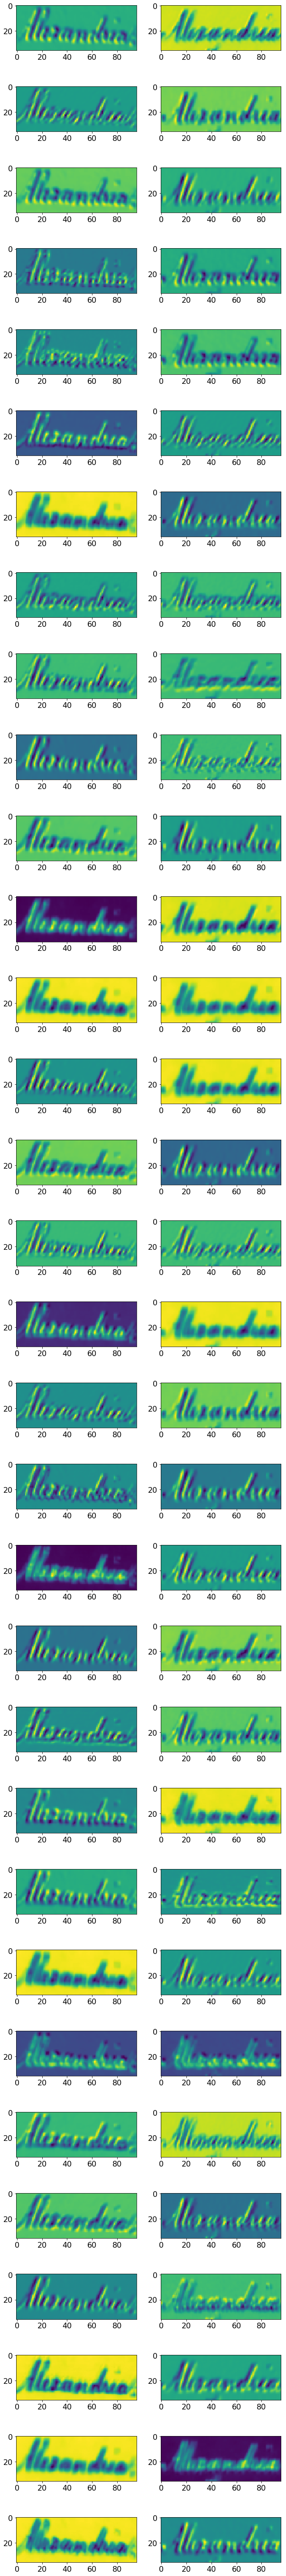

In [337]:
plt.figure(figsize=(10,100))
plot_weights(out)
plt.show()

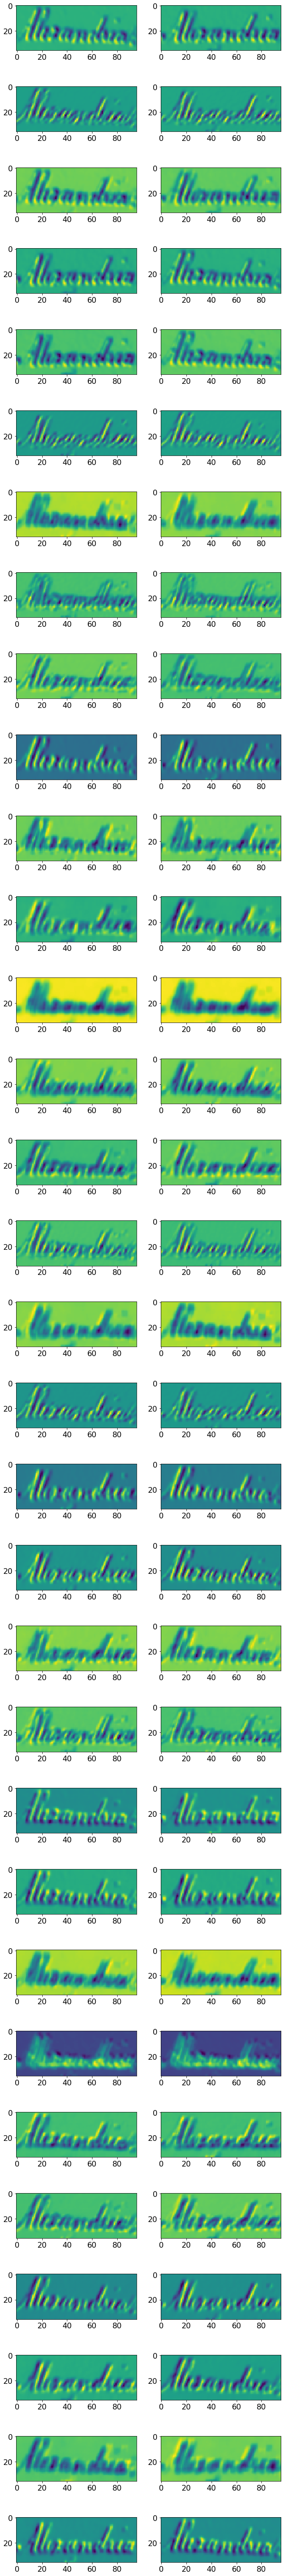

In [339]:
sampleab = torch.cat((a, b), 0).unsqueeze(0)
sampleba = torch.cat((b, a), 0).unsqueeze(0)
out_ab = classifier.conv1(sampleab).squeeze(0).unsqueeze(1).data.numpy()
out_ba = classifier.conv1(sampleba).squeeze(0).unsqueeze(1).data.numpy()
out = np.concatenate((out_ab, out_ba), 1)
plt.figure(figsize=(10,100))
plot_weights(out)
plt.show()

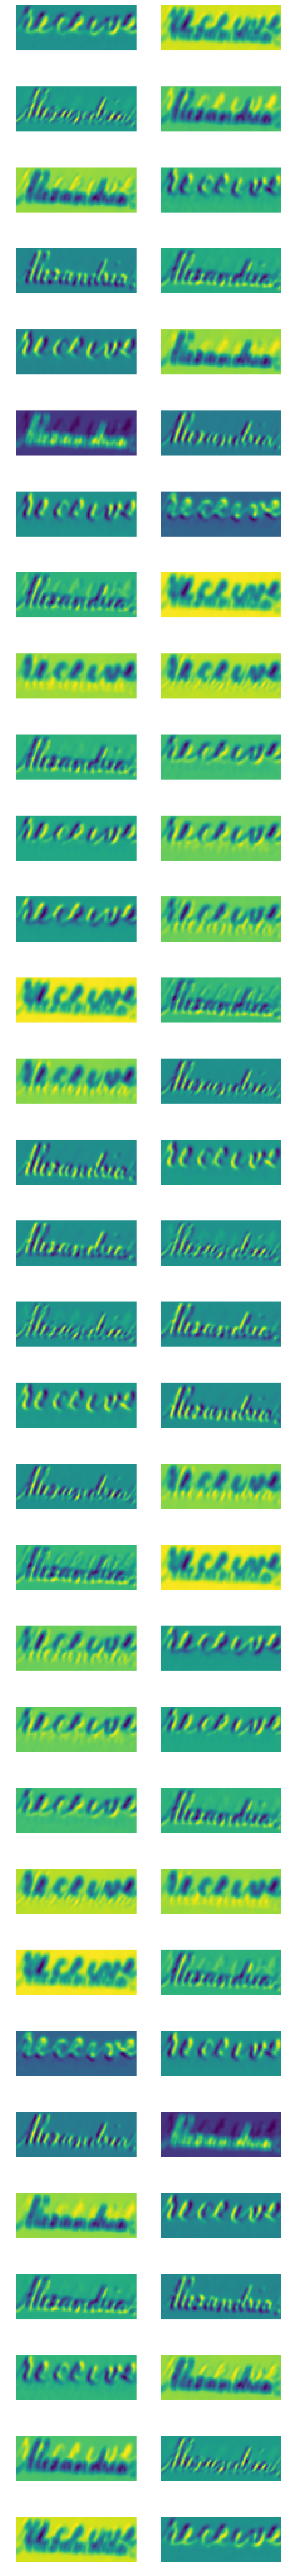

In [344]:
sampleac = torch.cat((a, c), 0).unsqueeze(0)
sampleca = torch.cat((c, a), 0).unsqueeze(0)
out_ac = regressor.conv1(sampleac).squeeze(0).unsqueeze(1).data.numpy()
out_ca = regressor.conv1(sampleca).squeeze(0).unsqueeze(1).data.numpy()
out = np.concatenate((out_ac, out_ac[::-1]), 1)
plt.figure(figsize=(10,100))
plot_weights(out)
plt.savefig("filters.png", dpi=300)
plt.show()